In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from itertools import chain, repeat
import os


def open_csv(path):
    return pd.read_csv(path)

def get_filenames(file_ending, directory):
    filenames = []
    for filename in os.listdir(directory):
        if filename.endswith(file_ending): 
            filenames.append(os.path.join(directory, filename))
            continue
        else:
            continue
    return filenames



directories = get_filenames('.json', 'data/database/')
list_of_dfs = [pd.read_json(directory, lines=True) for directory in directories]
result_df = pd.concat(list_of_dfs)
result_df = result_df.rename(columns={'request': 'first_language'})

result_df['first_language'] = result_df['first_language'].replace(['Deutsch'],'german')
result_df['first_language'] = result_df['first_language'].replace(['Polnisch'],'polish')
result_df['first_language'] = result_df['first_language'].replace(['Russisch'],'russian')
result_df['gender'] = result_df['gender'].replace(['weiblich'],'female')
result_df['gender'] = result_df['gender'].replace(['männlich'],'male')
result_df['gender'] = result_df['gender'].replace(['divers'],'indeterminate')

result_df.to_csv('./metadata_survey.csv', index = None, header=True)

def plot_save_count(df, path):
    plot = df\
        .value_counts()\
        .plot\
        .bar(x=[0], y=[1], rot=0)
    plot.grid(which='major', axis='y', linestyle='--')
    plot.get_figure().savefig(path, dpi=300, format='png', transparent=True)

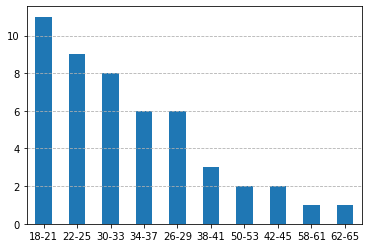

In [2]:
plot_save_count(result_df['age_range'], 'figs/age_ranges.png')

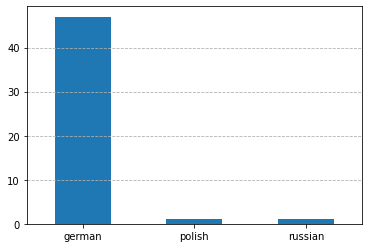

In [3]:
plot_save_count(result_df['first_language'], 'figs/first_langs.png')

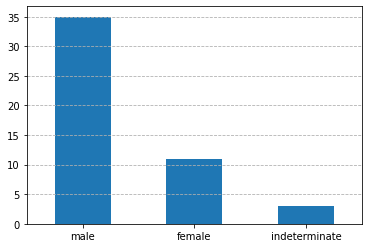

In [4]:
plot_save_count(result_df['gender'], 'figs/genders.png')

In [5]:
# path = '/Users/Tobias/Desktop/Bachelorarbeit/Code/VoiceControll/voice_control/src/main/result.csv'
path = '/Users/Tobias/Desktop/Bachelorarbeit/Code/VoiceControll/voice_control/src/main/transcription_results.csv'
df_csv = open_csv(path)
df = df_csv.loc[df_csv['TRANSCRIPTION_STRING'].str.len() != 1]
df['RESULT'] = np.where(df['EXPECTED_TEXT'] == df['TRANSCRIPTION_STRING'], 1, 0)

<ipython-input-5-d9a21e1cf8b5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RESULT'] = np.where(df['EXPECTED_TEXT'] == df['TRANSCRIPTION_STRING'], 1, 0)


In [6]:
def save_fig(fig, path):
    fig.tight_layout()
    fig.savefig(path, dpi=300, format='png', transparent=True)
    

def get_results_by(column, df_filtered):
    df_analysis = df_filtered.loc[:, df_filtered.columns.intersection([column,'RESULT'])]
    df_analysis[[column, 'RESULT']].groupby(['RESULT']).agg(['count'])
    df_counted = df_analysis.groupby([column, 'RESULT']).size().sort_values(ascending=False).reset_index(name='COUNT')
    df_piv = df_counted.pivot_table(index=column, columns="RESULT", values="COUNT")
    return df_piv

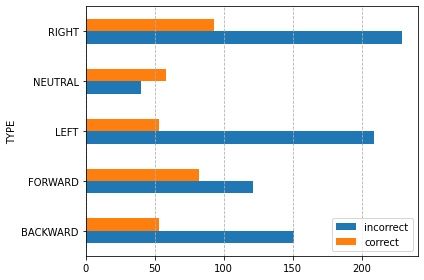

In [7]:
df_type = get_results_by('TYPE', df)
fig, ax = plt.subplots()
plot_type = df_type.plot(kind='barh', ax=ax)
ax.legend(["incorrect", "correct"])
ax.grid(which='major', axis='x', linestyle='--')

save_fig(fig, './figs/res_type.png')

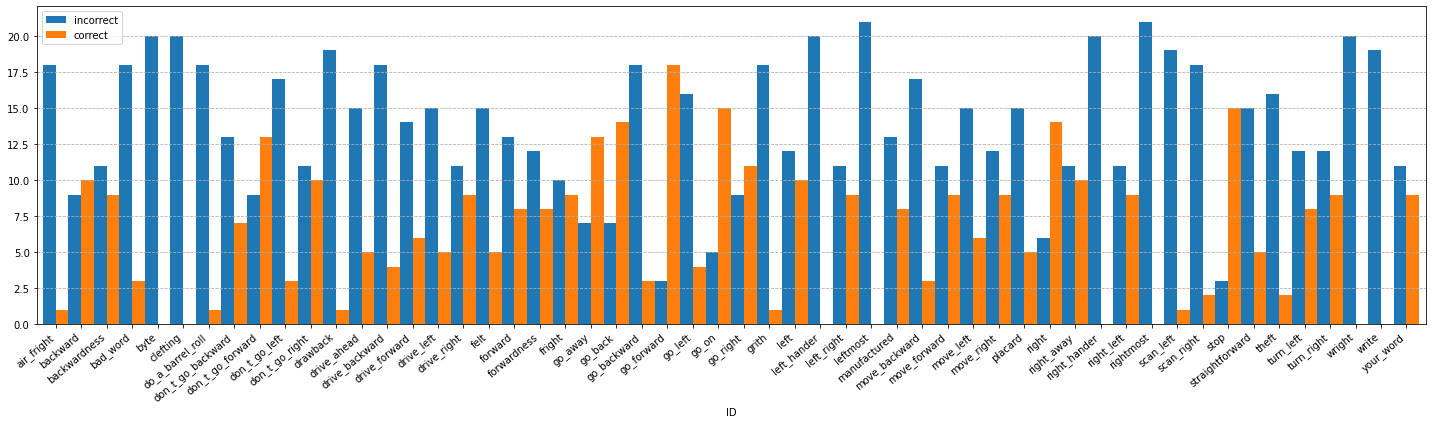

In [8]:
df_id = get_results_by('ID', df)
df_id.to_csv('results_id.csv')

fig, ax = plt.subplots()
plot_id = df_id.plot(kind='bar', width=1.0, figsize=(20,6), ax=ax)
plot_id.set_xticklabels(plot_id.get_xticklabels(), rotation=40, ha='right')
ax.legend(["incorrect", "correct"])
ax.grid(which='major', axis='y', linestyle='--')

save_fig(fig, './figs/res_id.png')

In [9]:
df.to_csv('analysis.csv')

In [10]:
def color_bars(df, title):
    generic_color =  'C0'
    match_color = 'm'
    colors = []
    for text in df.index:
        if(text == title):
            colors.append(match_color)
        else:
            colors.append(generic_color)
    return colors


def count_id(id_val, figx_size, figy_size, ax=None):
    specific_df = df[df['ID']==id_val]['TRANSCRIPTION_STRING']
    counts_df = specific_df.value_counts()
    title = df.loc[df['ID'] == id_val, 'EXPECTED_TEXT'].iloc[0]
    colors = color_bars(counts_df, title)
    fig = counts_df.plot(kind='bar', ax=ax, figsize=(figx_size, figy_size), title=title, color=colors)
    fig.set_xticklabels(fig.get_xticklabels(), rotation=40, ha ='right')    
    fig.yaxis.set_major_locator(MaxNLocator(integer=True))
    fig.grid(which='major', axis='y', linestyle='--')


def plot_subplot(id_list, title, xsize, ysize, figx_size, figy_size):
    fig, axs = plt.subplots(xsize, ysize)
    fig.suptitle(title)
    fig.subplots_adjust(hspace=4)
    for id_item, ax  in zip(id_list, axs.ravel()):
        count_id(id_item, figx_size, figy_size, ax)
    return fig

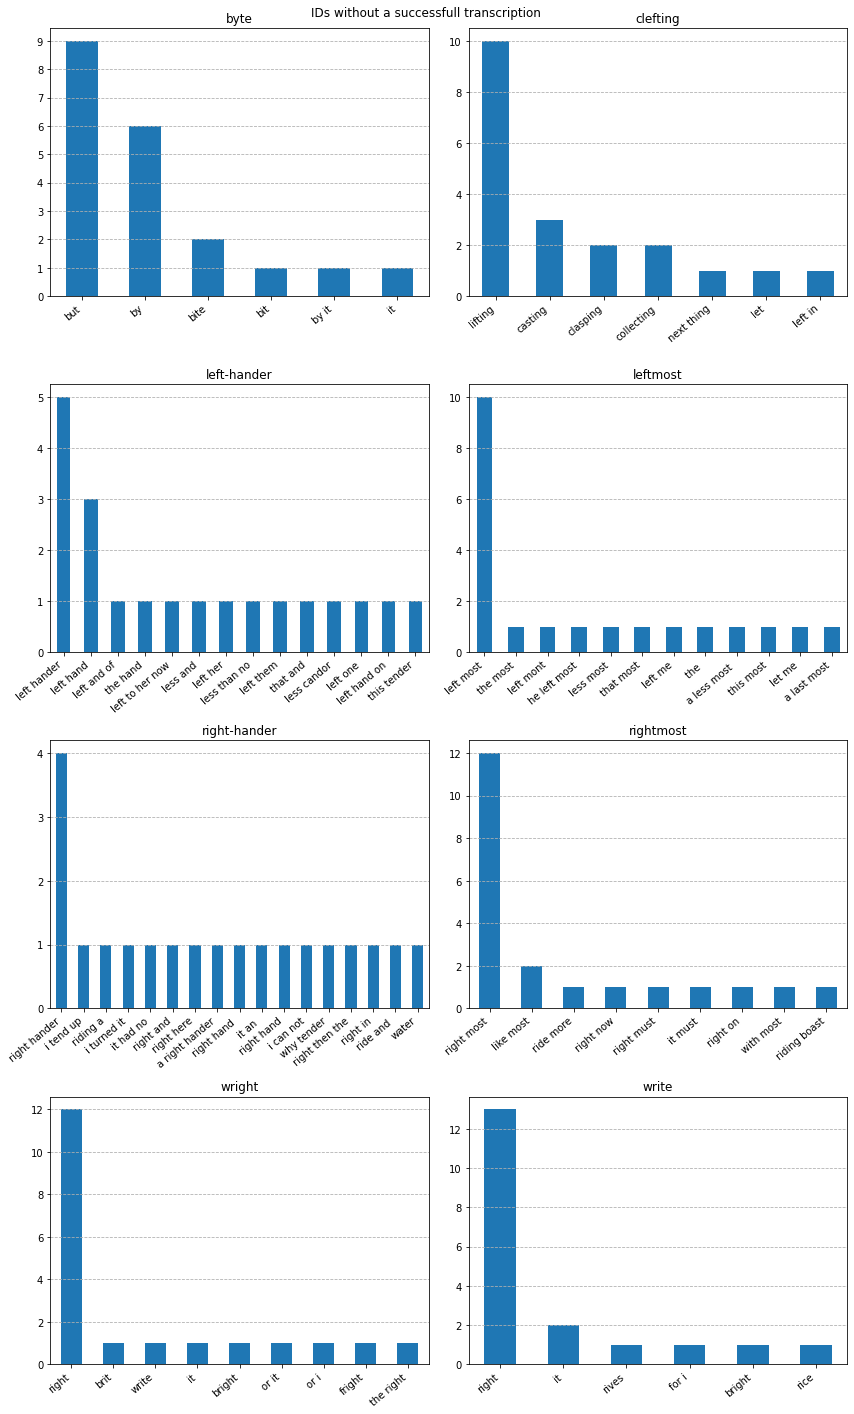

In [11]:
# mit byte kam es auch nicht klar, aber immerhin nicht 'right', sondern 'bite'. near miss
# mit clefting kam es garnicht klar, hat aber zumindest nicht 'left' verstanden
# es scheint 'left hander' statt 'left-hander'(korrekt) erkannt zu haben

no_hits = ['byte', 'clefting', 'left_hander', 'leftmost', 'right_hander', 'rightmost', 'wright', 'write']
no_hit_plot = plot_subplot(no_hits, 'IDs without a successfull transcription', 4,2, 12,20)


save_fig(no_hit_plot, './figs/no_hit.png')

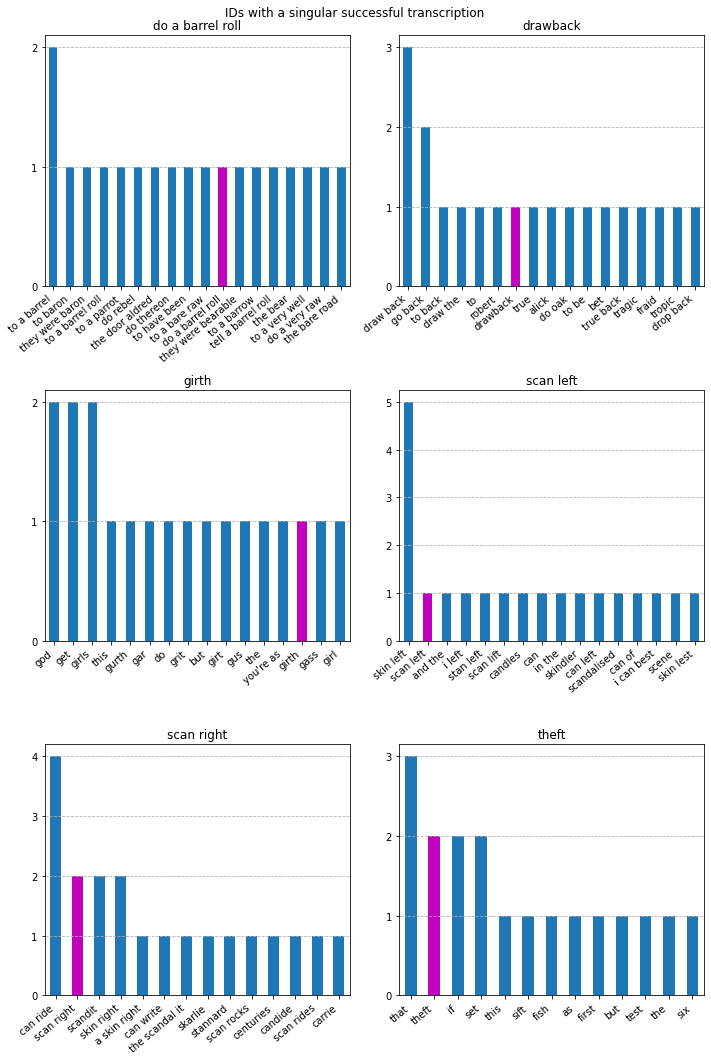

In [12]:
bare_hits = ['do_a_barrel_roll', 'drawback', 'grith', 'scan_left', 'scan_right', 'theft']
bare_hits_plot = plot_subplot(bare_hits, 'IDs with a singular successful transcription', 3,2, 10, 15)

save_fig(bare_hits_plot, './figs/bare_hit.png')

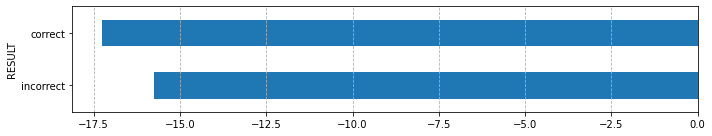

In [13]:
df_analysis = df.loc[:, df.columns.intersection(['TRANS_CONFIDENCE','RESULT'])]
df_mean = df_analysis[['TRANS_CONFIDENCE', 'RESULT']].groupby(['RESULT']).agg(['mean'])

df_mean.pivot_table(index='RESULT', columns="mean")
df_tidy = df_mean.rename(index={1:'correct', 0:'incorrect'})

fig, ax = plt.subplots()
plot_mean = df_tidy.plot(kind='barh', legend=False, ax=ax,  figsize=(10,2))
ax.grid(which='major', axis='x', linestyle='--')

save_fig(fig, './figs/mean_confidence.png')

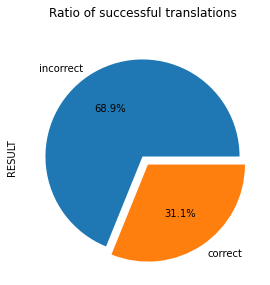

In [14]:
df_analysis = df.loc[:, df.columns.intersection(['ID'])]
df_count = df_analysis[['ID']]

df_percent = df['RESULT'].value_counts().rename(index={1:'correct', 0:'incorrect'}).to_frame()

fig, ax = plt.subplots()
fig_percent = df_percent.plot.pie(figsize=(10,2), subplots=True, ax=ax, y='RESULT', title="Ratio of successful translations", legend=False, autopct='%1.1f%%', explode=(0, 0.1), shadow=False, startangle=0)

save_fig(fig, './figs/percent.png')

In [15]:
def mean_conf_count_by_(column, df_filtered, rename):
    df_analysis = df_filtered.loc[:, df_filtered.columns.intersection([column,'RESULT'])]
    df_analysis[[column, 'RESULT']].groupby(['RESULT']).agg(['count'])
    df_counted = df_analysis.groupby([column, 'RESULT']).size().sort_values(ascending=False).reset_index(name='COUNT')
    df_piv = df_counted.pivot_table(index=column, columns="RESULT", values="COUNT")
    df_conf_age = df.loc[:, df.columns.intersection(['TRANS_CONFIDENCE', column])]
    df_conf_age = df_conf_age[['TRANS_CONFIDENCE', column]].groupby([column]).agg(['mean'])
    result = df_piv.join(df_conf_age, on=column)
    result.reset_index(inplace=True)
    df_tidy_res = result.rename(columns={column: rename, 0: 'incorrect', 1:'correct', result.columns[-1]:'confidence'}).set_index([rename])
    return df_tidy_res




/usr/local/lib/python3.9/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


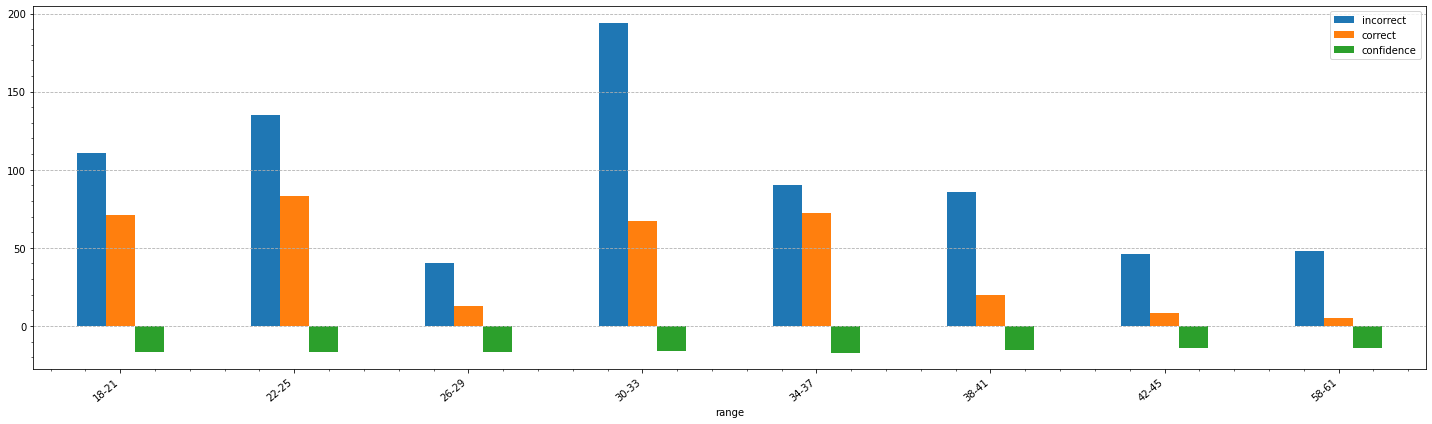

In [16]:
df_age_res_count = mean_conf_count_by_('AGE_RANGE', df, 'range')

fig, ax = plt.subplots()
plot_mean = df_age_res_count.plot(kind='bar', legend=True, ax=ax,  figsize=(20,6))
plot_mean.set_xticklabels(plot_mean.get_xticklabels(), rotation=40, ha='right')
ax.grid(which='major', axis='y', linestyle='--')
plot_mean.minorticks_on()

save_fig(fig, './figs/res_age.png')

In [17]:
df_age_res_count

,incorrect,correct,confidence
range,,,
18-21,111,71,-16.508421
22-25,135,83,-16.789310
26-29,40,13,-16.867203
30-33,194,67,-16.100878
34-37,90,72,-17.279384
38-41,86,20,-15.165185
42-45,46,8,-13.937974
58-61,48,5,-13.961367


/usr/local/lib/python3.9/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


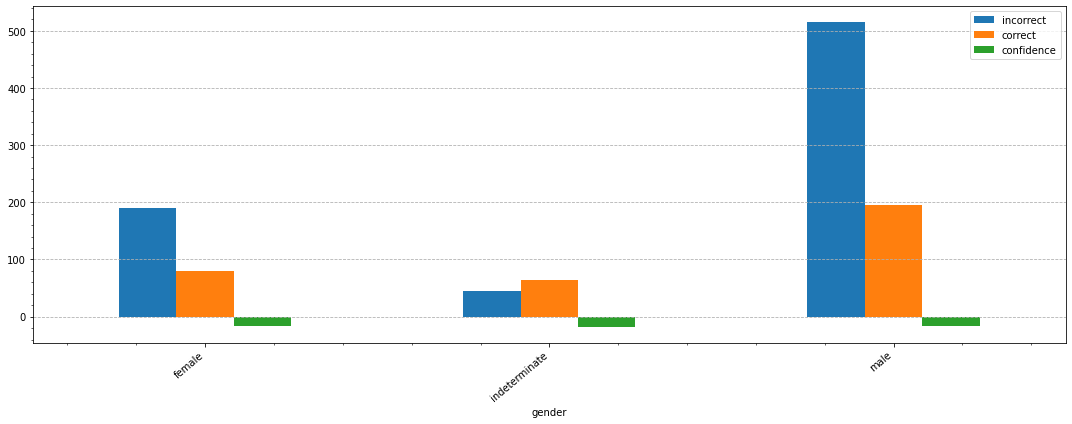

In [18]:
df_gender_res_count = mean_conf_count_by_('GENDER', df, 'gender')

fig, ax = plt.subplots()
plot_mean = df_gender_res_count.plot(kind='bar', legend=True, ax=ax,  figsize=(15,6))
plot_mean.set_xticklabels(plot_mean.get_xticklabels(), rotation=40, ha='right')
ax.grid(which='major', axis='y', linestyle='--')
plot_mean.minorticks_on()

save_fig(fig, './figs/res_gender.png')

In [19]:
df.head(5)

,Unnamed: 0,Unnamed: 0.1,ID,EXPECTED_RESULT,EXPECTED_TEXT,IDEA,TYPE,PATH,UUID,AGE_RANGE,FIRST_LANGUAGE,GENDER,TRANSCRIPTION,TRANSCRIPTION_STRING,TRANS_CONFIDENCE,RESULT
0,0,0,your_word,0,your word,9,FORWARD,/Users/Tobias/Desktop/Bachelorarbeit/Code/Voic...,eeb0bcca-bd9c-48ed-9742-58e99db59a89_2020-09-1...,38-41,german,male,<Swig Object of type 'Metadata *' at 0x13a870eb0>,you were,-15.903429,0
1,1,1,right_hander,0,right-hander,4,RIGHT,/Users/Tobias/Desktop/Bachelorarbeit/Code/Voic...,eeb0bcca-bd9c-48ed-9742-58e99db59a89_2020-09-1...,38-41,german,male,<Swig Object of type 'Metadata *' at 0x13a6831b0>,a right hander,-19.919182,0
2,2,2,backwardness,0,backwardness,7,BACKWARD,/Users/Tobias/Desktop/Bachelorarbeit/Code/Voic...,eeb0bcca-bd9c-48ed-9742-58e99db59a89_2020-09-1...,38-41,german,male,<Swig Object of type 'Metadata *' at 0x139844c70>,backwardness,-14.665235,1
3,3,3,byte,0,byte,8,RIGHT,/Users/Tobias/Desktop/Bachelorarbeit/Code/Voic...,eeb0bcca-bd9c-48ed-9742-58e99db59a89_2020-09-1...,38-41,german,male,<Swig Object of type 'Metadata *' at 0x139844c30>,bite,-17.760239,0
4,4,4,left,1,left,5,LEFT,/Users/Tobias/Desktop/Bachelorarbeit/Code/Voic...,eeb0bcca-bd9c-48ed-9742-58e99db59a89_2020-09-1...,38-41,german,male,<Swig Object of type 'Metadata *' at 0x139844cf0>,left,-17.932017,1


In [20]:
idea_df = open_csv('/Users/Tobias/Desktop/Bachelorarbeit/Code/VoiceControll/Auswertung/idea_codes.csv')

idea_df

,TYPE,IDEA
0,two discrete commands,0
1,anagram,1
2,coincidental inclusions,2
3,combination,3
4,compound,4
5,generic,5
6,negation,6
7,not a move order,7
8,rhyme,8
9,sounds similar,9


In [21]:
import matplotlib.ticker as ticker



def plot_idea_one(row, ax=None):
    df_plot = get_results_by('ID', df.loc[df['IDEA'] == row['IDEA']])
    plt_two = df_plot.plot.barh(title=row['TYPE'])
    plt_two.legend(["incorrect", "correct"])
    plt_two.grid(which='major', axis='x', linestyle='--')
    plt_two.xaxis.set_major_locator(ticker.MultipleLocator(5))


    save_fig(plt_two.get_figure(), './figs/ideas/idea_comp_' + str(row['IDEA']) + '.png')

    
    
def plot_idea_two(row):
    specific_df = df[df['IDEA']==row['IDEA']]
    filtered = specific_df[['TRANSCRIPTION_STRING','ID']]
    counts_df = filtered.value_counts().head(7)
    headers=[]
    
    for index, value in counts_df.iteritems():
        headers.append('* ' + str(index[0]) + '\n' + str(index[1]))
        
    ax = counts_df.plot.barh(title=row['TYPE'], figsize=(12,8))
    ax.grid(which='major', axis='x', linestyle='--')
    ax.set_yticklabels(headers)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))


    save_fig(ax.get_figure(), './figs/ideas/idea_trans_' + str(row['IDEA']) + '.png')

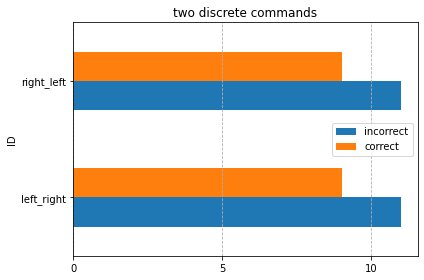

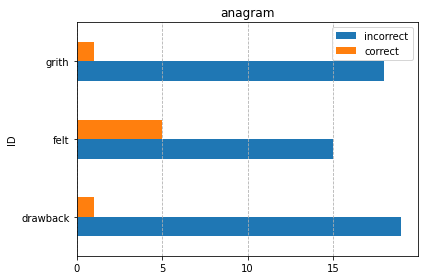

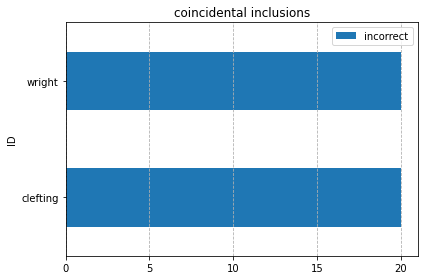

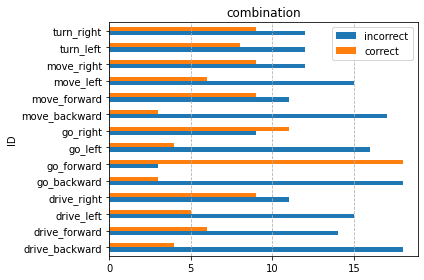

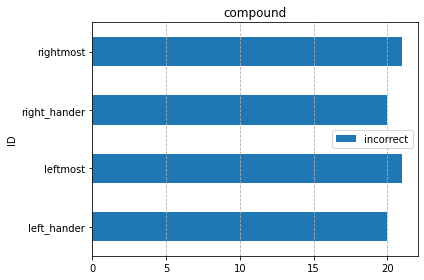

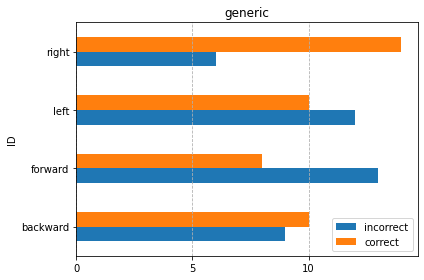

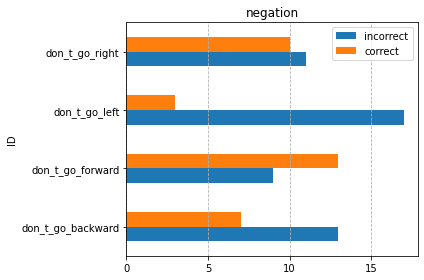

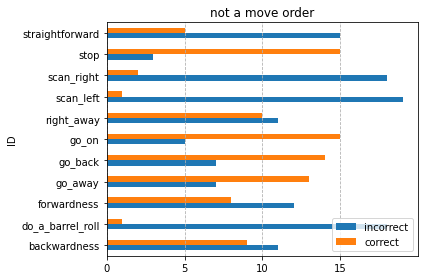

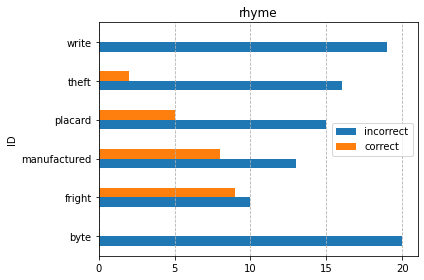

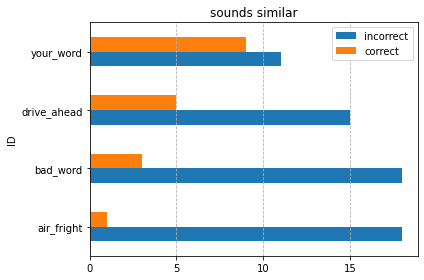

In [22]:
for index, row in idea_df.iterrows():
    plot_idea_one(row)

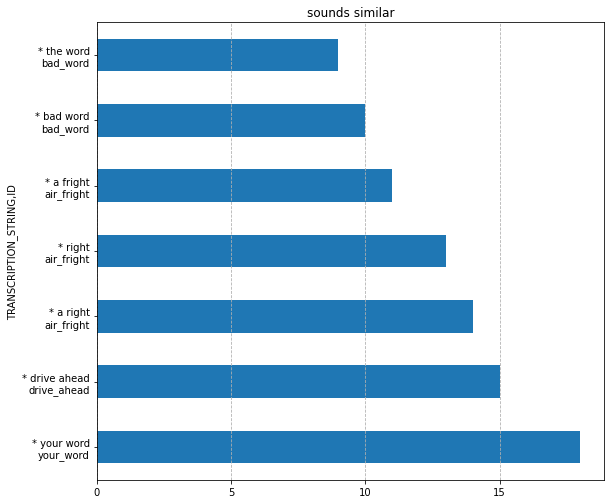

In [23]:
for index, row in idea_df.iterrows():
    plot_idea_two(row)

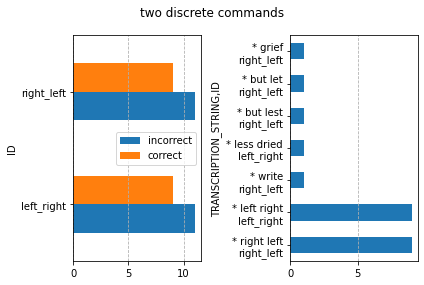

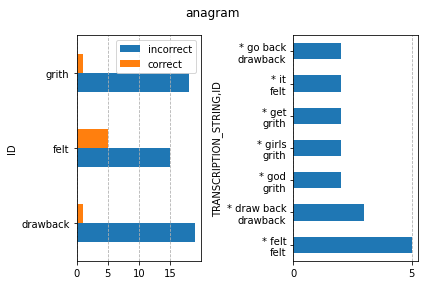

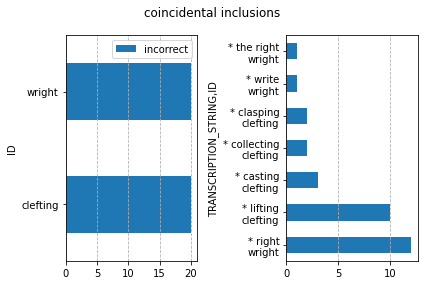

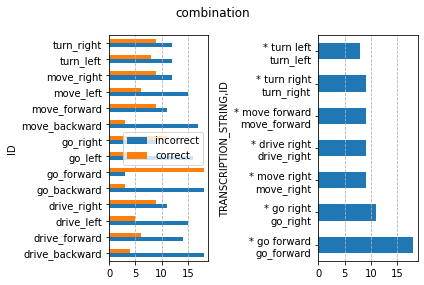

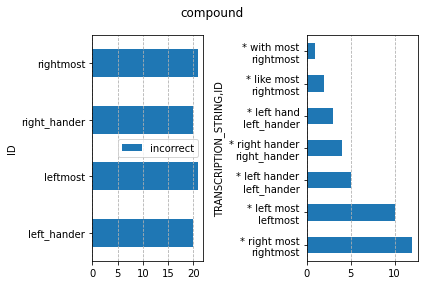

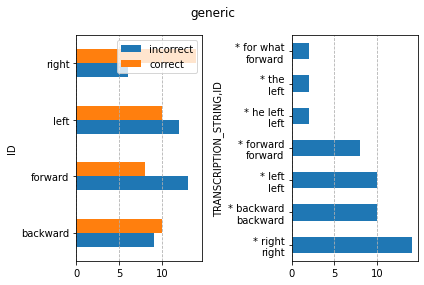

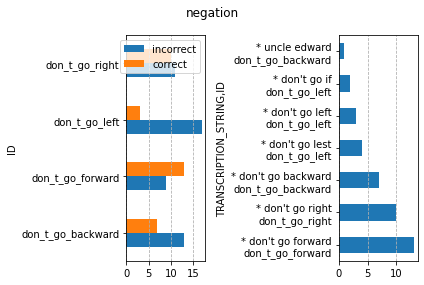

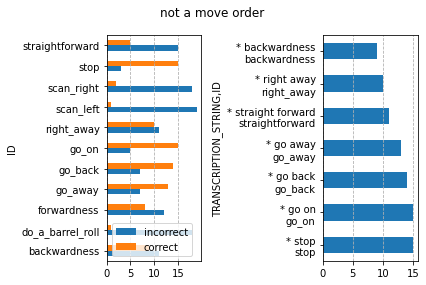

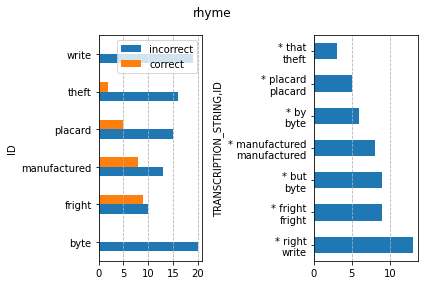

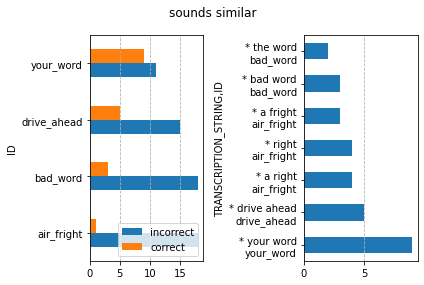

In [24]:
def plot_idea_one_both(row, ax=None):
    df_plot = get_results_by('ID', df.loc[df['IDEA'] == row['IDEA']])
    
    fig = df_plot.plot(kind='barh', ax=ax)
    fig.legend(["incorrect", "correct"])
    fig.grid(which='major', axis='x', linestyle='--')
    fig.xaxis.set_major_locator(MaxNLocator(integer=True))
    fig.xaxis.set_major_locator(ticker.MultipleLocator(5))




    
    
def plot_idea_two_both(row, ax=None):
    specific_df = df[df['IDEA']==row['IDEA']]
    filtered = specific_df[['TRANSCRIPTION_STRING','ID']]
    counts_df = filtered.value_counts().head(7)
    headers=[]
    
    for index, value in counts_df.iteritems():
        headers.append('* ' + str(index[0]) + '\n' + str(index[1]))
        
    fig = counts_df.plot(kind='barh', ax=ax)
    fig.grid(which='major', axis='x', linestyle='--')
    fig.set_yticklabels(headers)
    fig.xaxis.set_major_locator(MaxNLocator(integer=True))
    fig.xaxis.set_major_locator(ticker.MultipleLocator(5))





    

def plot_idea(row):
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(row['TYPE'])
    fig.subplots_adjust(hspace=4)
    plot_idea_one_both(row, axs[0])
    plot_idea_two_both(row, axs[1])
    
    return fig


for index, row in idea_df.iterrows():
    fig = plot_idea(row)
    save_fig(fig, './figs/ideas/idea_' + str(row['IDEA']) + '.png')

In [25]:
def plot_idea_two_full(row):
    specific_df = df[df['IDEA']==row['IDEA']]
    filtered = specific_df[['TRANSCRIPTION_STRING','ID']]
    counts_df = filtered.value_counts().head(25)
    headers=[]
    
    for index, value in counts_df.iteritems():
        headers.append('* ' + str(index[0]) + '\n' + str(index[1]))


        
    ax = counts_df.plot.barh(title=row['TYPE'], figsize=(18,23))
    ax.grid(which='major', axis='x', linestyle='--')
    ax.set_yticklabels(headers)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))




    save_fig(ax.get_figure(), './figs/ideas/idea_trans_full_' + str(row['IDEA']) + '.png')

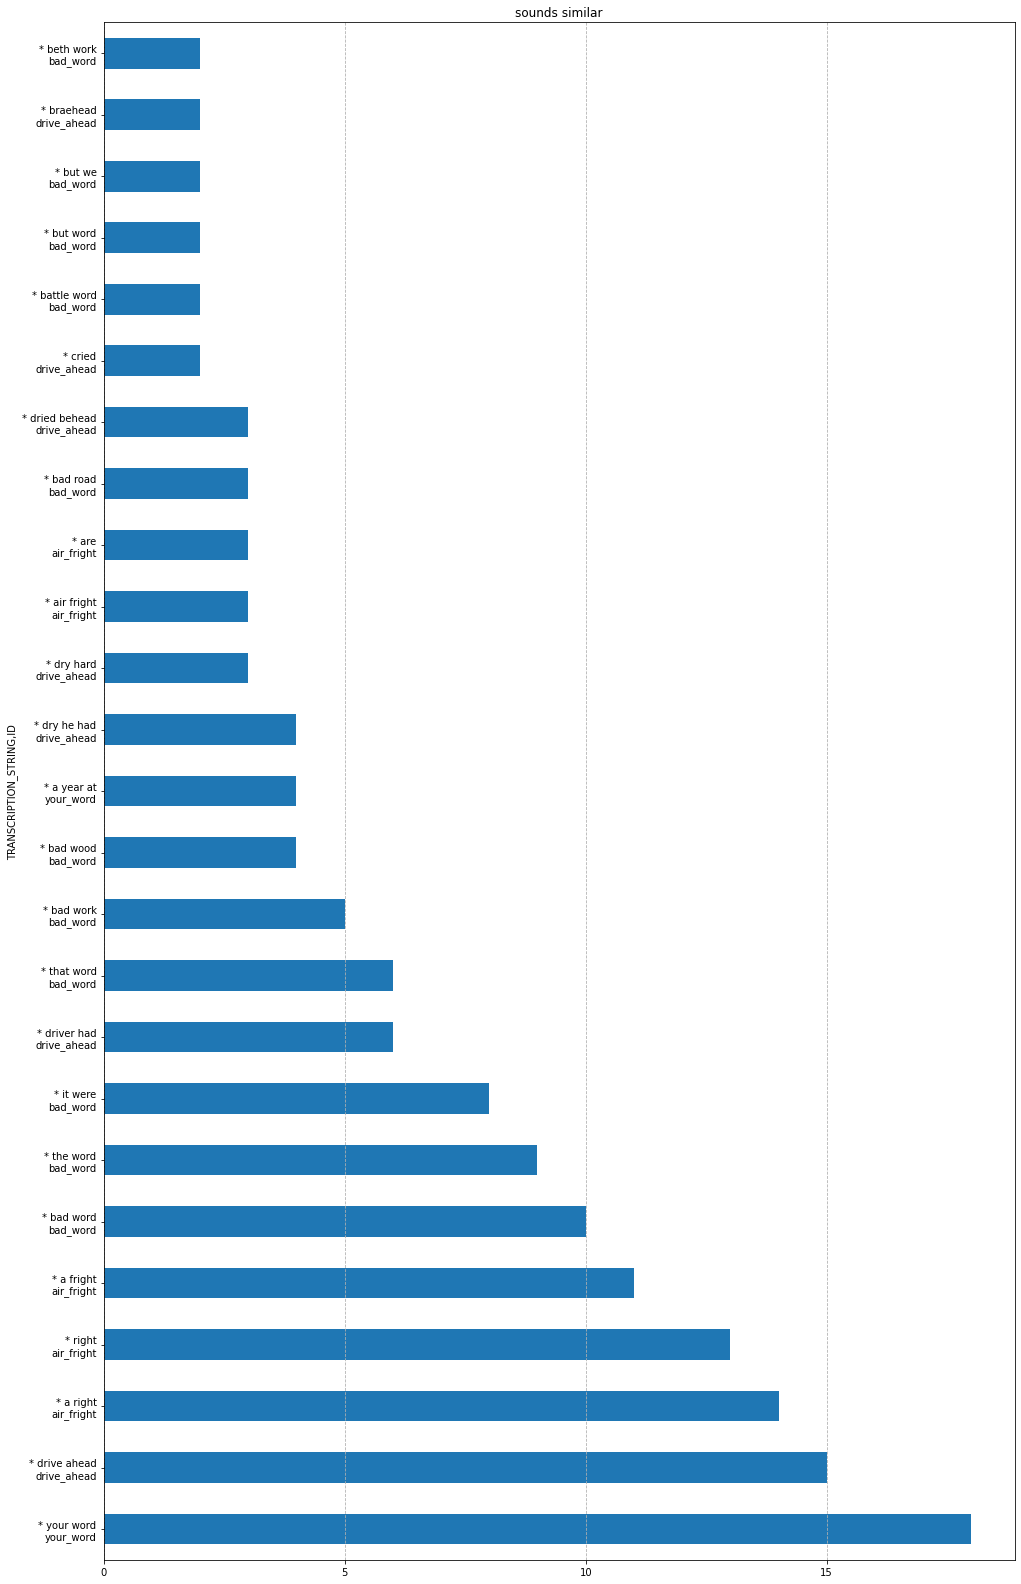

In [26]:
for index, row in idea_df.iterrows():
    plot_idea_two_full(row)

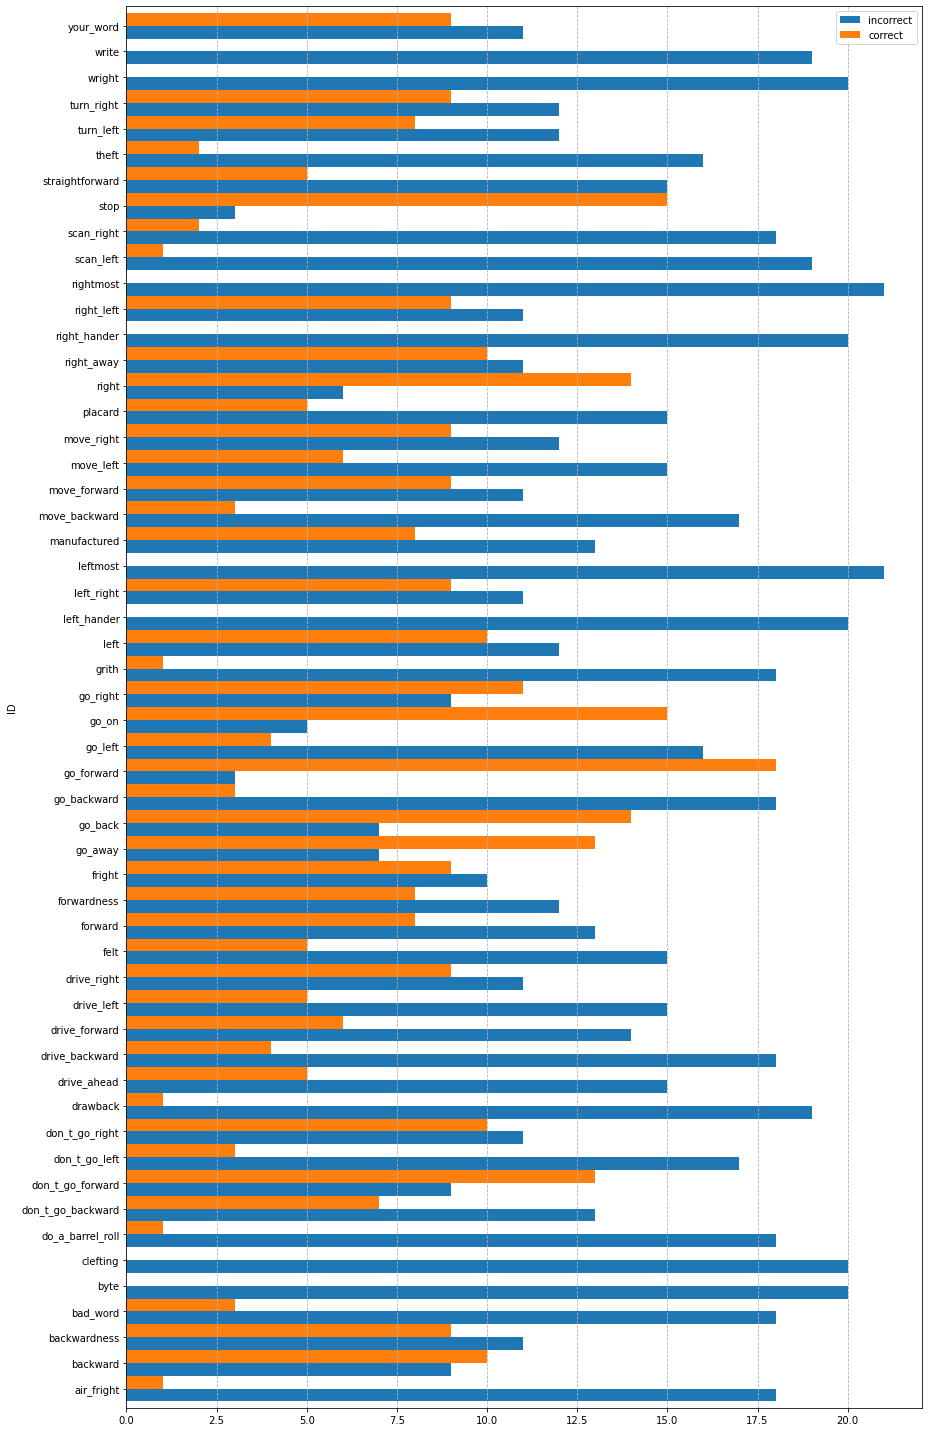

In [33]:
df_id = get_results_by('ID', df)
df_id.to_csv('results_id.csv')

fig, ax = plt.subplots()
plot_id = df_id.plot(kind='barh', width=1.0, figsize=(13,20), ax=ax)
ax.legend(["incorrect", "correct"])
ax.grid(which='major', axis='x', linestyle='--')

save_fig(fig, './figs/res_id_barh.png')